In [148]:
# 기본
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

# 경고 뜨지 않게 설정
import warnings
warnings.filterwarnings('ignore')

# 그래프 설정
sns.set()

# 그래프 기본 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
# plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['figure.figsize'] = 12, 6
plt.rcParams['font.size'] = 14
plt.rcParams['axes.unicode_minus'] = False

# 데이터 전처리 알고리즘
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

# 학습용과 검증용으로 나누는 함수
from sklearn.model_selection import train_test_split

# 교차 검증
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

# 평가함수
# 분류용
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

# 회귀용
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# 모델의 최적의 하이퍼 파라미터를 찾기 위한 도구
from sklearn.model_selection import GridSearchCV

# 머신러닝 알고리즘 - 분류
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
from catboost import CatBoostClassifier

# 머신러닝 알고리즘 - 회귀
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import VotingRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import StackingRegressor

# 학습 모델 저장을 위한 라이브러리
import pickle

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [2]:
# data_type = "train"
# month = "07"
# category = "잔액정보"

# local
root_path = '../../data'

# colab
# root_path = '/content/drive/MyDrive/12조 파이널프로젝트/data'

#drive_folder = f'{root_path}/스탯티즈_Raw_data/'

In [3]:
df1 = pd.read_csv(f'{root_path}/FA_투수_기존+2025.csv')

In [4]:
# 수치형 컬럼 자동 선택 (ID, 이름, 구분 등은 제외)
stat_cols = df1.select_dtypes(include=['int64', 'float64']).columns.difference(['FA년도', '플레이년도']).tolist()

# 선수별 평균 계산
df_stat = df1.groupby('선수명')[stat_cols].mean().reset_index()

In [5]:
df_cat = (
    df1.sort_values(['선수명', '플레이년도'])
        .groupby('선수명')
        .last()
        .reset_index()[['선수명', '투', '세부 포지션']]
)

In [6]:
df_final = pd.merge(df_stat, df_cat, on='선수명', how='left')

- 투, 세부 포지션 : 원핫 인코딩

In [21]:
df_final['투'] = df_final['투'].apply(
    lambda x: '우투' if '우' in str(x)
    else '좌투'
)

In [23]:
df_encoded = pd.get_dummies(df_final, columns=['투', '세부 포지션'], prefix=['투', '포지션'])

In [33]:
print(df_encoded.columns.tolist())

['선수명', '2루타허용', '3루타허용', 'ERA', 'FA 계약 연수', 'FA 계약 총액', 'FIP', '게임수', '구원 WAR', '구원 이닝', '구원등판', '국대출전횟수', '나이', '볼넷허용', '블론세이브', '사구허용', '사사구', '선발 WAR', '선발 이닝', '선발등판', '세이브', '승리', '연봉', '완봉', '완투', '원클럽맨여부', '이닝수', '자책점', '종합 WAR', '탈삼진', '투구수', '패전', '폭투', '피안타', '피장타율', '피홈런', '홀드', '투_우투', '투_좌투', '포지션_CP', '포지션_RP', '포지션_SP']


In [47]:
# 계약 연수가 0이거나 결측인 경우 제외
df_encoded = df_encoded[df_encoded['FA 계약 연수'] > 0].copy()

# AAV 다시 계산
df_encoded['AAV'] = df_encoded['FA 계약 총액'] / df_encoded['FA 계약 연수']

- Feature importance

In [85]:
# 데이터 분리
X = df_encoded.drop(columns=['AAV', '선수명', 'FA 계약 총액'])
y = df_encoded['AAV']

In [87]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

## 랜덤 포레스트

In [90]:
# 1️⃣ 모델 정의 & 학습
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [92]:
# 2️⃣ 예측 & 평가
y_pred_rf = rf_model.predict(X_val)
rmse_rf = mean_squared_error(y_val, y_pred_rf, squared=False)
r2_rf = r2_score(y_val, y_pred_rf)
mes_rf = np.mean(y_pred_rf - y_val)  # 평균 오차 (예측 - 실제)


# 결과 출력
print(f"✅ [Random Forest]")
print(f"   RMSE: {rmse_rf:,.0f} 원")
print(f"   R²:   {r2_rf:.4f}")
print(f"   MES:  {mes_rf:.4f} 원")

✅ [Random Forest]
   RMSE: 29,939 원
   R²:   0.7923
   MES:  8506.1111 원


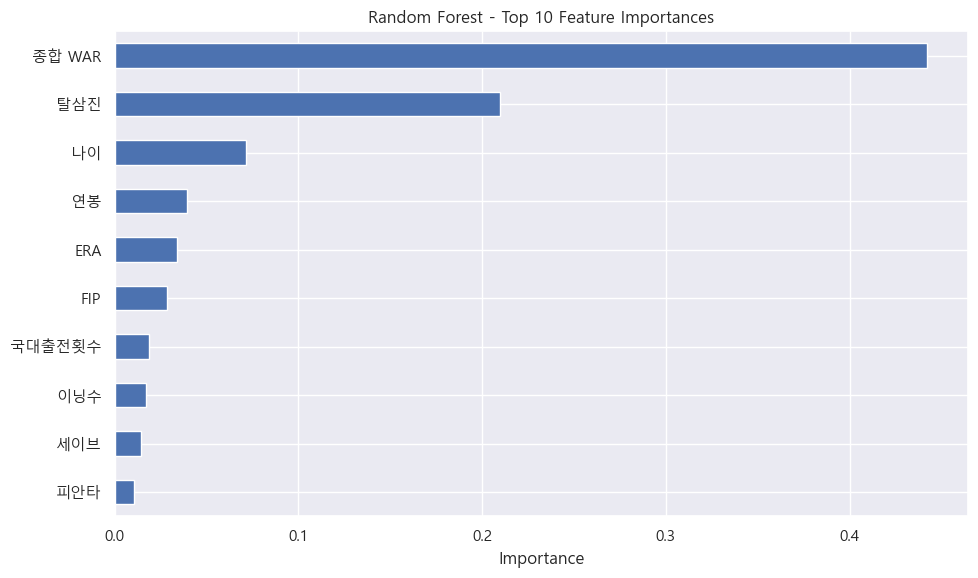

In [107]:
# 3️⃣ feature importance 시각화
feat_imp_rf = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
feat_imp_rf.head(10)[::-1].plot(kind='barh')
plt.title("Random Forest - Top 10 Feature Importances")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

## LGBM

In [97]:
# 1️⃣ 모델 정의 & 학습
lgbm_model = LGBMRegressor(random_state=42)
lgbm_model.fit(X_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000383 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 565
[LightGBM] [Info] Number of data points in the train set: 58, number of used features: 34
[LightGBM] [Info] Start training from score 87706.896720
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

LGBMRegressor(random_state=42)

In [101]:
# 2️⃣ 예측 & 평가
y_pred_lgbm = lgbm_model.predict(X_val)
rmse_lgbm = mean_squared_error(y_val, y_pred_lgbm, squared=False)
r2_lgbm = r2_score(y_val, y_pred_lgbm)
mes_lgbm = np.mean(y_pred_lgbm - y_val)

# 결과 출력
print(f"✅ [LGBM]")
print(f"   RMSE: {rmse_lgbm:,.0f} 원")
print(f"   R²:   {r2_lgbm:.4f}")
print(f"   MES:  {mes_lgbm:.4f} 원")

✅ [LGBM]
   RMSE: 40,408 원
   R²:   0.6217
   MES:  5131.3913 원


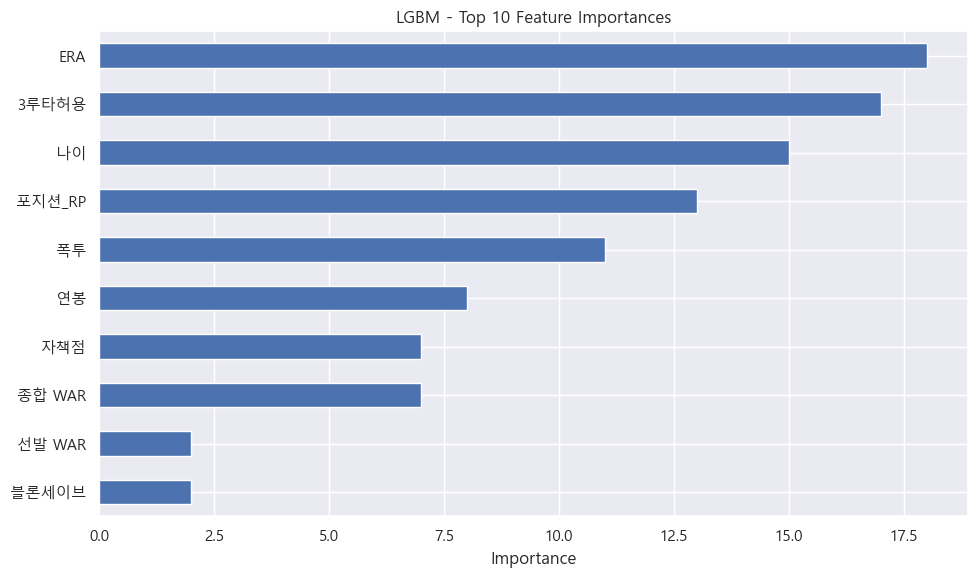

In [130]:
feat_imp_lgbm = pd.Series(lgbm_model.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
feat_imp_lgbm.head(10)[::-1].plot(kind='barh')
plt.title("LGBM - Top 10 Feature Importances")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

## XGBoost

In [110]:
# 1️⃣ 모델 정의 & 학습
xgb_model = XGBRegressor(random_state=42)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [112]:
# 2️⃣ 예측 & 평가
y_pred_xgb = xgb_model.predict(X_val)

rmse_xgb = mean_squared_error(y_val, y_pred_xgb, squared=False)
r2_xgb = r2_score(y_val, y_pred_xgb)
mes_xgb = np.mean(y_pred_xgb - y_val)

# 결과 출력
print(f"✅ [XGBoost]")
print(f"   RMSE: {rmse_xgb:,.0f} 원")
print(f"   R²:   {r2_xgb:.4f}")
print(f"   MES:  {mes_xgb:.4f} 원")

✅ [XGBoost]
   RMSE: 36,675 원
   R²:   0.6884
   MES:  10044.3065 원


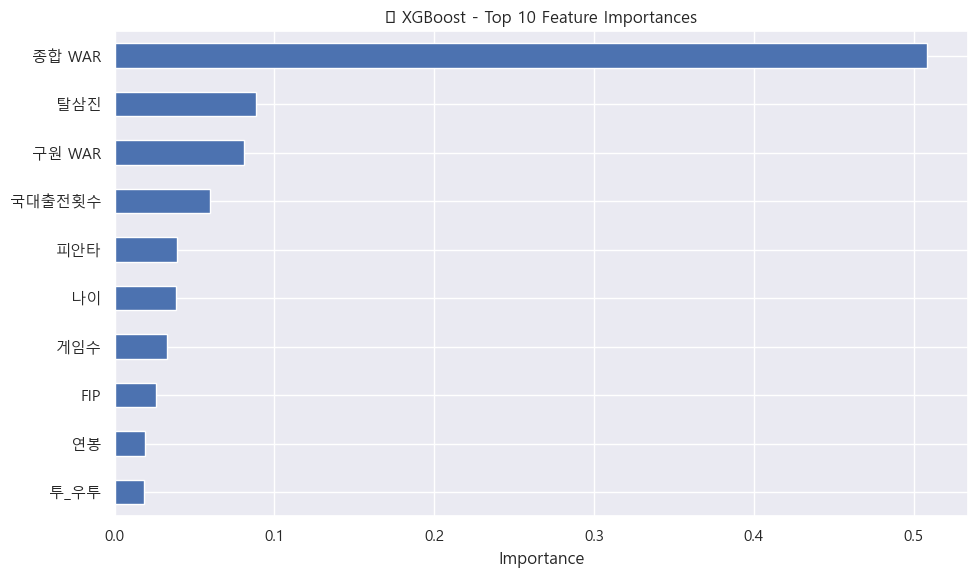

In [114]:
feat_imp_xgb = pd.Series(xgb_model.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
feat_imp_xgb.head(10)[::-1].plot(kind='barh')
plt.title("🎯 XGBoost - Top 10 Feature Importances")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

## CatBoost

In [136]:
# 1️⃣ 모델 정의 및 학습
cat_model = CatBoostRegressor(verbose=0, random_state=42)
cat_model.fit(X_train, y_train)

In [138]:
# 2️⃣ 예측 & 평가
y_pred_cat = cat_model.predict(X_val)
rmse_cat = mean_squared_error(y_val, y_pred_cat, squared=False)
r2_cat = r2_score(y_val, y_pred_cat)
mes_cat = np.mean(y_pred_cat - y_val)

# 결과 출력
print("✅ [CatBoost]")
print(f"   RMSE: {rmse_cat:,.0f} 원")
print(f"   R²:   {r2_cat:.4f}")
print(f"   MES:  {mes_cat:.4f} 원")

✅ [CatBoost]
   RMSE: 35,605 원
   R²:   0.7063
   MES:  5972.8135 원


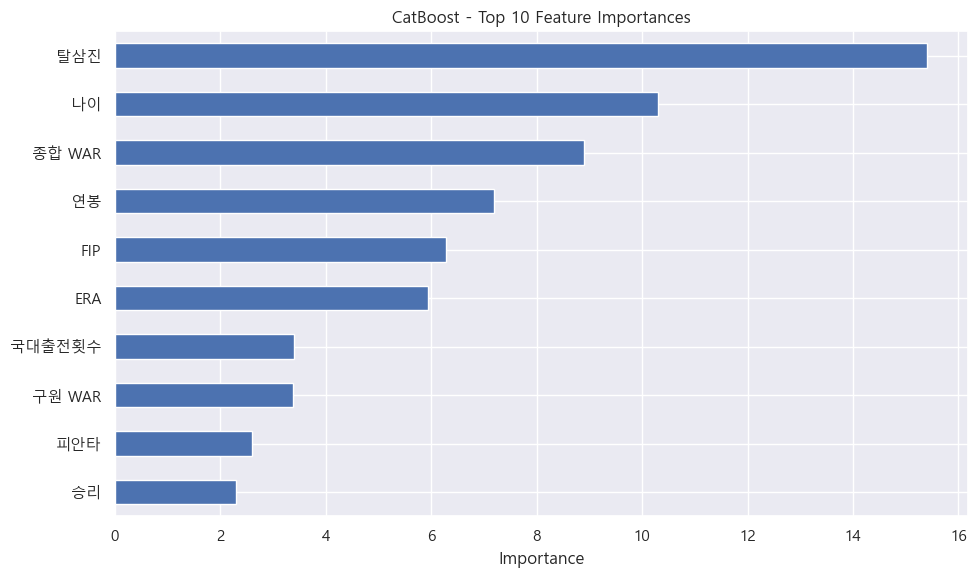

In [150]:
# 3️⃣ Feature Importance
cat_importance = pd.Series(cat_model.feature_importances_, index=X.columns).sort_values(ascending=False)[:10]

plt.figure(figsize=(10, 6))
cat_importance[::-1].plot(kind='barh')
plt.title("CatBoost - Top 10 Feature Importances")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

## Stacking Regressor (RF + LGBM + XGB → Ridge)

In [163]:
# 1️⃣ 구성 모델들
estimators = [
    ('rf', RandomForestRegressor(random_state=42)),
    ('lgbm', LGBMRegressor(random_state=42)),
    ('xgb', XGBRegressor(random_state=42)),
    ('cat', CatBoostRegressor(verbose=0, random_state=42))
]

In [166]:
# 2️⃣ 스태킹 모델 정의 및 학습
stack_model = StackingRegressor(
    estimators=estimators,
    final_estimator=Ridge(),
    n_jobs=-1
)
stack_model.fit(X_train, y_train)

StackingRegressor(estimators=[('rf', RandomForestRegressor(random_state=42)),
                              ('lgbm', LGBMRegressor(random_state=42)),
                              ('xgb',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None,
                                            fea...
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None, ...)),
                              ('cat',
                               <catboost.core.CatBoostRegressor object at 0x0000025EA835D130>)],
                  final_estimator=Ridge(), n_jobs=-1)

In [168]:
# 3️⃣ 예측 & 평가
y_pred_stack = stack_model.predict(X_val)
rmse_stack = mean_squared_error(y_val, y_pred_stack, squared=False)
r2_stack = r2_score(y_val, y_pred_stack)
mes_stack = np.mean(y_pred_stack - y_val)

print("✅ [Stacking Regressor]")
print(f"   RMSE: {rmse_stack:,.0f} 원")
print(f"   R²:   {r2_stack:.4f}")
print(f"   MES:  {mes_stack:.4f} 원")

✅ [Stacking Regressor]
   RMSE: 31,824 원
   R²:   0.7654
   MES:  13335.8589 원


## SHAP 분석 (LGBM)

In [171]:
import shap

In [179]:
# 1️⃣ Explainer 
explainer = shap.TreeExplainer(lgbm_model)

In [185]:
# 2️⃣ SHAP 값 계산
shap_values = explainer.shap_values(X_val)

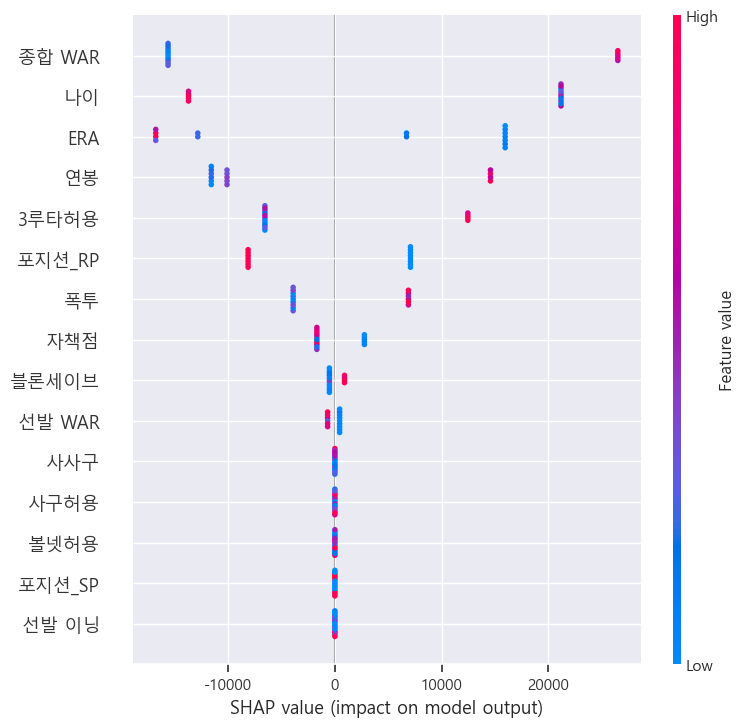

In [187]:
# 3️⃣ summary plot (전체 특성 영향도 시각화)
shap.summary_plot(shap_values, X_val, max_display=15)

In [189]:
# waterfall plot은 개별 예측에 대한 설명용
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0], X_val.iloc[0])

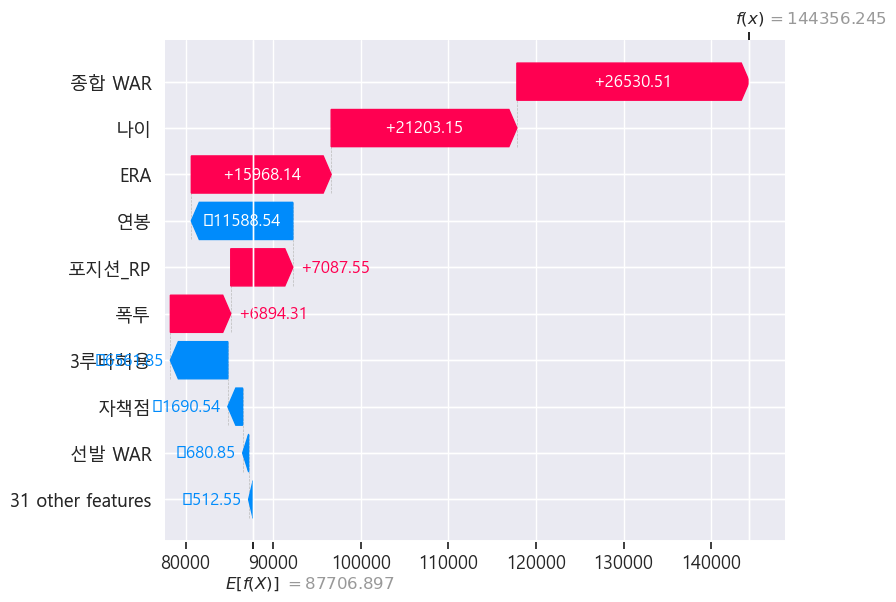

In [191]:
# 최신 SHAP에서는 waterfall이 예쁘고 직관적
shap.plots._waterfall.waterfall_legacy(explainer.expected_value, shap_values[0], feature_names=X_val.columns)

In [197]:
# 1. best_model 지정
best_model = lgbm_model  # 또는 cat_model

# 2. 전체 데이터 예측
df_encoded['AAV_pred'] = best_model.predict(X)

# 3. 오차 계산
df_encoded['AAV_gap'] = df_encoded['AAV_pred'] - df_encoded['AAV']

# 4. 과대평가 TOP 5
print("📈 과대평가 선수 TOP5")
display(df_encoded.sort_values('AAV_gap', ascending=False)[['선수명', 'AAV', 'AAV_pred', 'AAV_gap']].head())

# 5. 과소평가 TOP 5
print("📉 과소평가 선수 TOP5")
display(df_encoded.sort_values('AAV_gap')[['선수명', 'AAV', 'AAV_pred', 'AAV_gap']].head())

📈 과대평가 선수 TOP5


,선수명,AAV,AAV_pred,AAV_gap
65,주권,40000.0,109329.397120,69329.397120
0,강영식,42500.0,109471.557798,66971.557798
24,배영수,70000.0,121870.030654,51870.030654
63,정찬헌,43000.0,92849.355776,49849.355776
49,이재학,30000.0,78104.517170,48104.517170


📉 과소평가 선수 TOP5


,선수명,AAV,AAV_pred,AAV_gap
4,구창모,208333.333333,144356.244579,-63977.088754
27,손승락,150000.000000,96839.869170,-53160.130830
43,윤석민,225000.000000,178756.356601,-46243.643399
34,엄상백,195000.000000,152578.294238,-42421.705762
17,노경은,83333.333333,42311.133166,-41022.200167
